<a href="https://colab.research.google.com/github/tinayiluo0322/Computer-Engineering-Machine-Learning-and-Deep-Neural-Nets-Projects/blob/main/Construct_Train_Optimize_CNN_Models/simplenn_cifar10_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing SimpleNN on CIFAR-10

#### Luopeiwen Yi


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os

In [3]:
# Change this to the absolute path where dataset.py and utils.py are stored
CODE_PATH = "/content/drive/MyDrive/CNN_hw"

# Add this path to sys.path so Python can find it
sys.path.append(CODE_PATH)

# Check if Colab can see the files
print("Files in directory:", os.listdir(CODE_PATH))

Files in directory: ['sample_predictions.csv', 'save_test_predictions.ipynb', '__pycache__', 'tools', 'simplenn-cifar10.ipynb']


# Optimization 1: Data Augmentation

## Step 1: Build the model


In [4]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### Sanity Check

In [6]:
# Define the SimpleNN model
model = SimpleNN()

# Create a dummy input tensor with the same shape as CIFAR-10 images (batch_size=1, channels=3, height=32, width=32)
dummy_input = torch.randn(1, 3, 32, 32)  # Shape: (1, 3, 32, 32)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Output shape: torch.Size([1, 10])
Total number of parameters: 82030


In [7]:
from torchsummary import summary

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the SimpleNN model and move it to the selected device
model = SimpleNN().to(device)

# Create a dummy input tensor and move it to the same device as the model
dummy_input = torch.randn(1, 3, 32, 32).to(device)  # Ensure input is on the same device

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print(f"Output shape: {output.shape}")  # Should be (1, 10) since we have 10 classes

# Count total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print model summary (Ensure model is on the correct device)
summary(model, (3, 32, 32), device=device.type)  # Specify the device

Using device: cuda
Output shape: torch.Size([1, 10])
Total number of parameters: 82030
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
            Conv2d-2           [-1, 16, 12, 12]           1,168
            Linear-3                  [-1, 120]          69,240
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 82,030
Trainable params: 82,030
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.31
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


## Step 1: Set up preprocessing functions


In [8]:
import torchvision.transforms as transforms

# Data augmentation for training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Random flipping
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  # Normalize
])

# No data augmentation for validation set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

ToTensor(): Converts PIL images to PyTorch tensors so they can be used in deep learning models.

Normalize(mean, std): Standardizes pixel values to a mean of (0.4914, 0.4822, 0.4465) and std of (0.2023, 0.1994, 0.2010), helping the model converge faster.


## Step 2: Set up dataset and dataloader


In [9]:
# Do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# A few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# Construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train  # Apply training preprocessing
)

val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val  # Apply validation preprocessing
)

# Construct dataloaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # Use predefined batch size
    shuffle=True,  # Shuffle training data for randomness
    num_workers=4  # Speed up data loading
)

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # Use predefined batch size
    shuffle=False,  # No need to shuffle validation data
    num_workers=4
)

# Sanity Check: Print dataset sizes
print(f"Train dataset size: {len(train_set)} images")
print(f"Validation dataset size: {len(val_set)} images")

# Check a single batch
sample_batch, sample_labels = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}, Labels shape: {sample_labels.shape}")


141746176it [00:04, 33045222.97it/s]                               


Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Train dataset size: 45000 images
Validation dataset size: 5000 images
Sample batch shape: torch.Size([128, 3, 32, 32]), Labels shape: torch.Size([128])


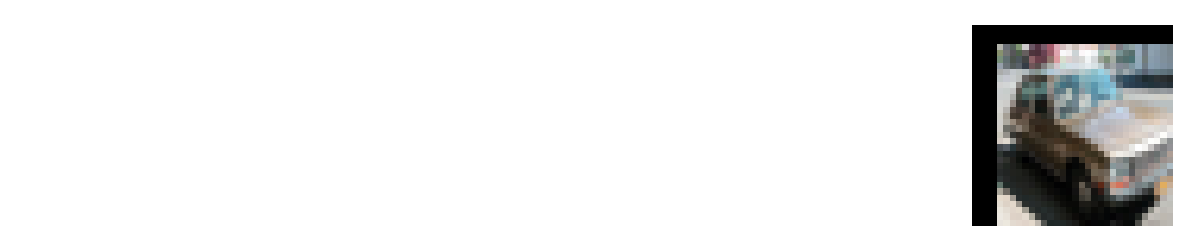

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load one batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Plot some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    imshow(images[i])
    axes[i].axis('off')
plt.show()

## Step 3: Instantiate SimpleNN model and deploy it to GPU devices.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the SimpleNN model
model = SimpleNN().to(device)  # Move model to GPU if available

# Verify that model parameters are on the correct device
for param in model.parameters():
    print(f"Parameter device: {param.device}")
    break  # Only need to check one parameter to confirm

Using device: cuda
Parameter device: cuda:0


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

In [12]:
import torch.nn as nn
import torch.optim as optim

# Hyperparameters (Do NOT change)
INITIAL_LR = 0.01  # Initial learning rate
MOMENTUM = 0.9  # Momentum for optimizer
REG = 1e-4  # L2 regularization (weight decay)

# Create loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Add optimizer (SGD with Momentum and L2 Regularization)
optimizer = optim.SGD(
    model.parameters(),  # Optimizing model parameters
    lr=INITIAL_LR,  # Learning rate
    momentum=MOMENTUM,  # Momentum factor
    weight_decay=REG  # L2 regularization
)

# Sanity check: Print optimizer details
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


## Step 5: Start the training process.



In [13]:
import torch
import os

# Hyperparameters
EPOCHS = 30  # Total number of training epochs
CHECKPOINT_FOLDER = "./saved_model"  # Folder for saving model checkpoints

# Track best validation accuracy
best_val_acc = 0
current_learning_rate = INITIAL_LR

# Ensure model is on the correct device
model.to(device)

model.eval()  # Set model to evaluation mode
initial_loss = 0
total_examples = 0
correct_examples = 0

with torch.no_grad():  # No gradient calculation
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Copy inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass: compute the output
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        initial_loss += loss.item()

        # Compute accuracy before training
        _, predicted = torch.max(outputs, 1)
        correct_examples += (predicted == targets).sum().item()
        total_examples += targets.size(0)

        # Only calculate on a small subset (e.g., 1 batch)
        if batch_idx == 0:
            break

# Compute initial average loss and accuracy
initial_loss /= (batch_idx + 1)
initial_acc = correct_examples / total_examples
print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")

# Start training
print("==> Training starts!")
print("="*50)

for i in range(EPOCHS):

    # Switch to train mode
    model.train()

    print("Epoch %d:" % i)

    # Track accuracy and loss
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    # Train the model for 1 epoch
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # Copy inputs and targets to the device (GPU or CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass: compute the output
        outputs = model(inputs)

        # Compute loss (cross-entropy loss expects raw logits, not softmax)
        loss = criterion(outputs, targets)

        # Zero the gradients (otherwise they accumulate)
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Apply gradient and update weights
        optimizer.step()

        # Track total loss
        train_loss += loss.item()

        # Count correct predictions
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        correct_examples += (predicted == targets).sum().item()
        total_examples += targets.size(0)

    # Compute average loss and accuracy
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

    # Validate on the validation dataset

    # Switch to evaluation mode
    model.eval()

    # Track accuracy and loss for validation
    total_examples = 0
    correct_examples = 0
    val_loss = 0

    # Disable gradient computation during validation (saves memory)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):

            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Count correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

    # Compute average loss and accuracy
    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

    # Save the model checkpoint if validation accuracy improves
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving best model...")
        state = {'state_dict': model.state_dict(), 'epoch': i, 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn_aug.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

Initial loss before training: 2.3060, Initial accuracy: 0.0625
==> Training starts!
Epoch 0:
Training loss: 2.0085, Training accuracy: 0.2501
Validation loss: 1.6731, Validation accuracy: 0.3782
Saving best model...

Epoch 1:
Training loss: 1.6064, Training accuracy: 0.4108
Validation loss: 1.4742, Validation accuracy: 0.4694
Saving best model...

Epoch 2:
Training loss: 1.4610, Training accuracy: 0.4710
Validation loss: 1.3351, Validation accuracy: 0.5214
Saving best model...

Epoch 3:
Training loss: 1.3638, Training accuracy: 0.5092
Validation loss: 1.2449, Validation accuracy: 0.5624
Saving best model...

Epoch 4:
Training loss: 1.3092, Training accuracy: 0.5301
Validation loss: 1.1837, Validation accuracy: 0.5840
Saving best model...

Epoch 5:
Training loss: 1.2530, Training accuracy: 0.5502
Validation loss: 1.1505, Validation accuracy: 0.6024
Saving best model...

Epoch 6:
Training loss: 1.2097, Training accuracy: 0.5691
Validation loss: 1.0959, Validation accuracy: 0.6170
Saving 

# Training with learning rate decay



In [14]:
# Hyperparameters
EPOCHS = 30  # Total number of training epochs
DECAY_EPOCHS = 10  # Decay learning rate every 10 epochs
DECAY = 0.1  # Reduce learning rate by a factor of 0.1

CHECKPOINT_FOLDER = "./saved_model"  # Folder for saving model checkpoints

# Track best validation accuracy
best_val_acc = 0
current_learning_rate = INITIAL_LR

# Reinitialize a fresh model (important to reset weights!)
model = SimpleNN().to(device)  # Create a new model

# Reset optimizer before the second training run
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

model.eval()  # Set model to evaluation mode
initial_loss = 0
total_examples = 0
correct_examples = 0

with torch.no_grad():  # No gradient calculation
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Copy inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass: compute the output
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        initial_loss += loss.item()

        # Compute accuracy before training
        _, predicted = torch.max(outputs, 1)
        correct_examples += (predicted == targets).sum().item()
        total_examples += targets.size(0)

        # Only calculate on a small subset (e.g., 1 batch)
        if batch_idx == 0:
            break

# Compute initial average loss and accuracy
initial_loss /= (batch_idx + 1)
initial_acc = correct_examples / total_examples
print(f"Initial loss before training: {initial_loss:.4f}, Initial accuracy: {initial_acc:.4f}")

# Start training
print("==> Training starts!")
print("="*50)

for i in range(EPOCHS):
    # Apply learning rate decay
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate *= DECAY  # Reduce learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print(f"Current learning rate has decayed to {current_learning_rate:.6f}")

    # Switch to train mode
    model.train()

    print("Epoch %d:" % i)

    # Track accuracy and loss
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    # Train the model for 1 epoch
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # Copy inputs and targets to the device (GPU or CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass: compute the output
        outputs = model(inputs)

        # Compute loss (cross-entropy loss expects raw logits, not softmax)
        loss = criterion(outputs, targets)

        # Zero the gradients (otherwise they accumulate)
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Apply gradient and update weights
        optimizer.step()

        # Track total loss
        train_loss += loss.item()

        # Count correct predictions
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        correct_examples += (predicted == targets).sum().item()
        total_examples += targets.size(0)

    # Compute average loss and accuracy
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

    # Validate on the validation dataset

    # Switch to evaluation mode
    model.eval()

    # Track accuracy and loss for validation
    total_examples = 0
    correct_examples = 0
    val_loss = 0

    # Disable gradient computation during validation (saves memory)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):

            # Copy inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass: compute the output
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Count correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)

    # Compute average loss and accuracy
    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print(f"Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")

    # Save the model checkpoint if validation accuracy improves
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving best model...")
        state = {'state_dict': model.state_dict(), 'epoch': i, 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn_aug_with_decay.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

Initial loss before training: 2.3005, Initial accuracy: 0.1484
==> Training starts!
Epoch 0:
Training loss: 1.9376, Training accuracy: 0.2751
Validation loss: 1.5997, Validation accuracy: 0.4060
Saving best model...

Epoch 1:
Training loss: 1.5789, Training accuracy: 0.4239
Validation loss: 1.4398, Validation accuracy: 0.4814
Saving best model...

Epoch 2:
Training loss: 1.4570, Training accuracy: 0.4697
Validation loss: 1.3324, Validation accuracy: 0.5266
Saving best model...

Epoch 3:
Training loss: 1.3775, Training accuracy: 0.5073
Validation loss: 1.2493, Validation accuracy: 0.5588
Saving best model...

Epoch 4:
Training loss: 1.3107, Training accuracy: 0.5306
Validation loss: 1.1943, Validation accuracy: 0.5784
Saving best model...

Epoch 5:
Training loss: 1.2498, Training accuracy: 0.5528
Validation loss: 1.1102, Validation accuracy: 0.6064
Saving best model...

Epoch 6:
Training loss: 1.2068, Training accuracy: 0.5691
Validation loss: 1.1122, Validation accuracy: 0.6106
Saving 

Validation accuracy increased with data augmentation to around 70%